# Natural Language Processing (NLP) Experiments

## Modeling and Evaluation

##### Colin Simon - 4/24/2020


## Document Summary
In this project, we will gather data from two different reddit.com subforums('subreddits'). Then, we'll attempt to create a model that can classify which subreddit any given post came from.

    - We will focus more on the effectiveness and analysis of the models in general than the utility of the predictor itself 

##### Key Files in folder:
    - 01 Preliminary code.ipynb <-- unused
    - 02 Pull Data - PRAW.ipynb <-- unused
    - 03 Pull Data Pushshift API.ipynb <-- this data used
    - 04 Explore Data.ipynb <-- you are here
    - Language differences between Saving and Investing.key <-- slide deck


### Contents:
- [1. Imports](#1.-Imports)
- [2. Data Gathering](#2.-Data-Gathering)
- [3. Exploratory Data Analysis (EDA)](#3.-Exploratory-Data-Analysis-(EDA))
- [4. Cleaning](#4.-Cleaning)
- [5. Combine Dataframes](#5.-Combine-Dataframes)
- [6. Modeling](#6.-Modeling)
- [7. Conclusions and Selections](#7.-Conclusions-and-Selections)
- [8. Bonus: Word Lists](#8.-Bonus:-Word-Lists)

# 1. Imports

In [240]:
# Basics
import pandas as pd
import numpy as np
import time
import missingno as msno
import matplotlib.pyplot as plt

# Modeling toolbox
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

# NLP specific
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Model imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import LinearSVC

# 2. Data Gathering
#### The "frugal_2.csv" file and "investing_2.csv" file were imported through Jupyter Notebook "03 Pull Data Pushshift API".

In [3]:
frugal = pd.read_csv('frugal_2.csv')

/Users/colinsimon/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


This warning message should be investigated. Let's look at data types below.

In [4]:
investing = pd.read_csv('investing_2.csv')

# 3. Exploratory Data Analysis (EDA)

In [5]:
frugal.dtypes

Unnamed: 0      object
created_utc     object
id              object
score          float64
title           object
selftext        object
full_link       object
subreddit       object
submission     float64
dtype: object

The data types from r/Frugal did not import very well. Created_utc, score, and submission should all be integers. We'll clean this below.

In [6]:
investing.dtypes

Unnamed: 0      int64
created_utc     int64
id             object
score           int64
title          object
selftext       object
full_link      object
subreddit      object
submission      int64
dtype: object

In [199]:
len(investing)

100000

In [205]:
len(frugal)

99998

#### View missing

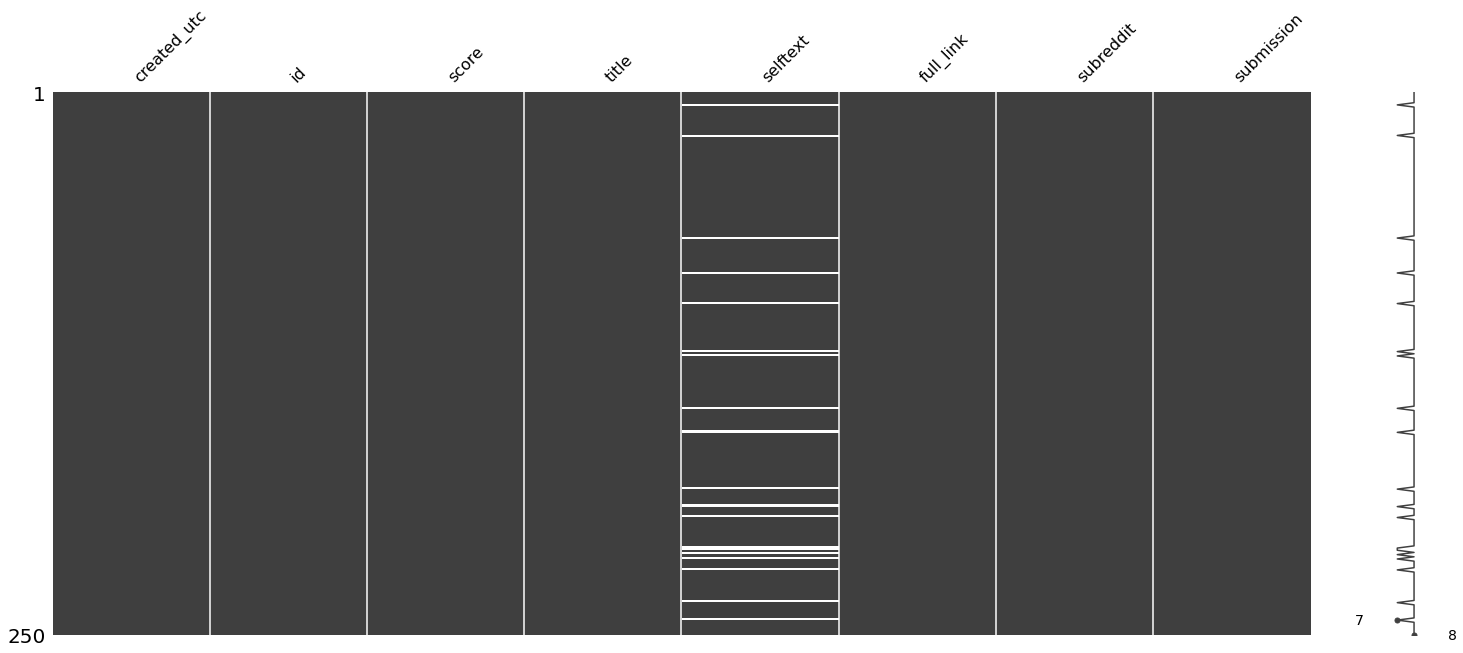

In [200]:
msno.matrix(investing.sample(250));

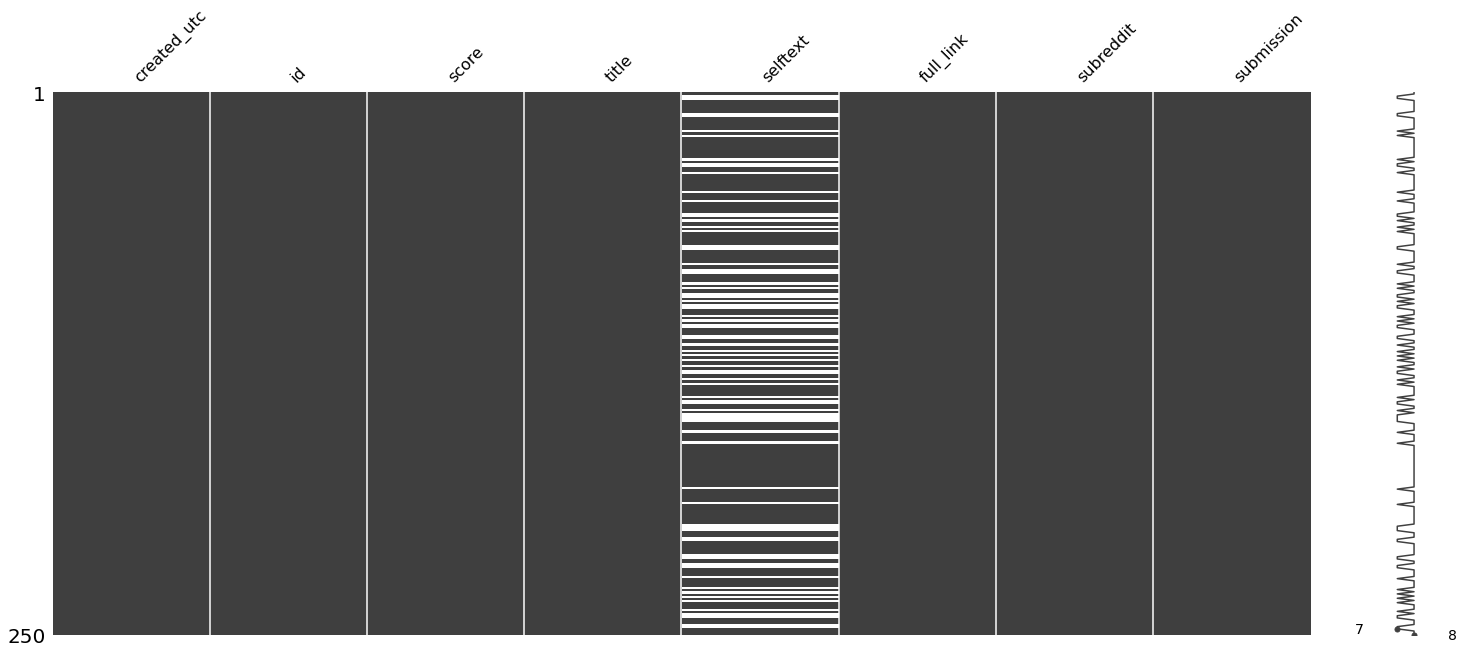

In [201]:
msno.matrix(frugal.sample(250));

Appears that Investing has much more in the "selftext" which is a proxy for what people write verus title.

In [204]:
investing.isna().sum()

created_utc       0
id                0
score             0
title             0
selftext       6404
full_link         0
subreddit         0
submission        0
dtype: int64

In [203]:
frugal.isna().sum()

created_utc        0
id                 0
score              0
title              0
selftext       31988
full_link          0
subreddit          0
submission         0
dtype: int64

# 4. Cleaning

We found several rows with NaN values in several columns. This function uses the 'subreddit' column to remove this group.

In [16]:
def drop_unnamed_nan(dataframe):
    # drop NaN values
    dataframe.dropna(subset=['subreddit'], how='all', inplace=True)
    # drop Unnamed column
    try:
        dataframe.drop('Unnamed: 0', 1, inplace=True)
    except:
        dataframe
    return dataframe

This function will fix object data types found primarily in the Frugal dataset.

In [8]:
def floats_to_ints(dataframe):
    # Disable chained assignments; from stackoverflow.com
    pd.options.mode.chained_assignment = None
    dataframe['created_utc'] = dataframe['created_utc'].astype(int)
    dataframe['score'] = dataframe['score'].astype(int)
    dataframe['submission'] = dataframe['submission'].astype(int)
    return dataframe

In [22]:
drop_unnamed_nan(investing)
floats_to_ints(investing)

,created_utc,id,score,title,selftext,full_link,subreddit,submission
0,1587535925,g5vvec,1,Where can I buy aapl stock in NZ?,"Hey guys, can anybody let me know where can I ...",https://www.reddit.com/r/investing/comments/g5...,investing,1
1,1587535891,g5vv5z,1,Is GLD Trust the best way to trade GOLD?,I’m looking for the best option to trade gold ...,https://www.reddit.com/r/investing/comments/g5...,investing,1
2,1587535866,g5vuzu,1,"""Who's going to pay the bill?""",I've watched the two interviews Ray Dalio has ...,https://www.reddit.com/r/investing/comments/g5...,investing,1
3,1587535645,g5vtgr,1,Conditional trades question,I'd like to use a one-triggers-a-one-cancels-t...,https://www.reddit.com/r/investing/comments/g5...,investing,1
4,1587535333,g5vrb9,1,Best way to learn/ get into stock market,What’s the best way to learn? I just don’t kno...,https://www.reddit.com/r/investing/comments/g5...,investing,1
...,...,...,...,...,...,...,...,...
99995,1478376265,5bbuay,0,Paper Trading Crude Oil CFDs at IG,[deleted],https://www.reddit.com/r/investing/comments/5b...,investing,1
99996,1478373621,5bbm4v,0,ELECTION DAY PROSPECT THREAD,Can we talk about stocks to look out for on el...,https://www.reddit.com/r/investing/comments/5b...,investing,1
99997,1478372131,5bbhfk,21,Howard Schultz on Retail,I've said on this sub for a while now that we ...,https://www.reddit.com/r/investing/comments/5b...,investing,1
99998,1478372103,5bbhc2,0,How do i deduct stock losses for IRS tax deduc...,Say for the entire year of 2016 I bought one s...,https://www.reddit.com/r/investing/comments/5b...,investing,1


In [23]:
drop_unnamed_nan(frugal)
floats_to_ints(frugal)

,created_utc,id,score,title,selftext,full_link,subreddit,submission
0,1587531253,g5uy8g,1,If you are a frugal entrepreneur and small bus...,"I work as a software developer, but I have alw...",https://www.reddit.com/r/Frugal/comments/g5uy8...,frugal,1
1,1587529942,g5uob9,1,"Food Baby - App to find cheap, nutritious food...",[Food Baby · foodbaby.app](https://web.foodbab...,https://www.reddit.com/r/Frugal/comments/g5uob...,frugal,1
2,1587527758,g5u71u,1,$70 Greenhouse,NaN,https://www.reddit.com/r/Frugal/comments/g5u71...,frugal,1
3,1587526543,g5tx48,1,Never buying bread again. I realized I can bak...,NaN,https://www.reddit.com/r/Frugal/comments/g5tx4...,frugal,1
4,1587524345,g5tefs,1,Make your grocery store croissants bakery qual...,NaN,https://www.reddit.com/r/Frugal/comments/g5tef...,frugal,1
...,...,...,...,...,...,...,...,...
99999,1363066675,1a4swl,10,I take a whole pasta casserole to work for lun...,I bake pasta casseroles in a disposable alumin...,https://www.reddit.com/r/Frugal/comments/1a4sw...,frugal,1
100000,1363063387,1a4ppl,1193,"Wow, Ziplock beating No Name by a penny! What ...",NaN,https://www.reddit.com/r/Frugal/comments/1a4pp...,frugal,1
100001,1363058148,1a4job,4,The Good Followed by the Bad!!,This past weekend I over came a huge bill and ...,https://www.reddit.com/r/Frugal/comments/1a4jo...,frugal,1
100002,1363056495,1a4hkc,15,"Film, show, or documentary style video on bein...","hello all,\n\nAfter finding this subreddit I h...",https://www.reddit.com/r/Frugal/comments/1a4hk...,frugal,1


# 5. Combine dataframes

This function also adds the "title" and the "subtext" columns into one "string to rule them all"

In [78]:
def df_add(df1, df2):
    combined = df1.append(df2)
    classification = {
        'frugal': 0,
        'investing': 1,
    }
    combined['result'] = combined['subreddit'].map(classification)
    combined['words'] = combined['title'] + ' ' + combined['selftext'] 
    return combined

In [79]:
combined = df_add(frugal, investing)

In [80]:
combined.head()

,created_utc,id,score,title,selftext,full_link,subreddit,submission,result,words
0,1587531253,g5uy8g,1,If you are a frugal entrepreneur and small bus...,"I work as a software developer, but I have alw...",https://www.reddit.com/r/Frugal/comments/g5uy8...,frugal,1,0,If you are a frugal entrepreneur and small bus...
1,1587529942,g5uob9,1,"Food Baby - App to find cheap, nutritious food...",[Food Baby · foodbaby.app](https://web.foodbab...,https://www.reddit.com/r/Frugal/comments/g5uob...,frugal,1,0,"Food Baby - App to find cheap, nutritious food..."
2,1587527758,g5u71u,1,$70 Greenhouse,NaN,https://www.reddit.com/r/Frugal/comments/g5u71...,frugal,1,0,NaN
3,1587526543,g5tx48,1,Never buying bread again. I realized I can bak...,NaN,https://www.reddit.com/r/Frugal/comments/g5tx4...,frugal,1,0,NaN
4,1587524345,g5tefs,1,Make your grocery store croissants bakery qual...,NaN,https://www.reddit.com/r/Frugal/comments/g5tef...,frugal,1,0,NaN


# 6. Modeling

These initial functions will allow us to easily score data and train-test-split quickly if we end up switching features or gathering new data sets.

In [169]:
# scoring function adapted from Magnus Big' project 3
def score(model, X, y):
    preds = model.predict(X)

#     print(f'{model} train score:', np.round(model.score(X, y),2))
    print(f'{model} test score:', np.round(model.score(X, y),2))

    # Get confusion matrix and unravel
    tn, fp, fn, tp = confusion_matrix(y, preds).ravel() # 1-dimension array
    print(f'\nAccuracy: {round((tp+tn)/len(y),3)}')
    print(f'Sensitivity: {round(tp/(tp+fn),3)}')
    print(f'Specificity: {round(tn/(tn+fp),3)}')
    print(f'Precision: {round(tp/(tp+fp),3)}')
    

In [151]:
# train-test-split
# function idea adapted from Scott Armstrong Ames project
def train_test_split_func(features, dataframe):
    X = dataframe[features]
    y = dataframe['result']
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size = 0.2,
                                                   random_state=42,
                                                   stratify = y)
    print('train-test-splitted')

In [84]:
features = 'words'

In [86]:
train_test_split_func(features,combined)

train-test-splitted


### Vectorizers

In [152]:
#Instantiate, fit, transform both vectorizers
cvec2 = CountVectorizer()
xtrain_cv = cvec2.fit_transform(X_train)
xtest_cv = cvec2.transform(X_test)

tfidf2 = TfidfVectorizer()
xtrain_tf = tfidf2.fit_transform(X_train)
xtest_tf = tfidf2.transform(X_test)

#### Parameters

In [154]:
#set up parameters
cv_params = {
    'cvec__max_features': [100, 500],
    'cvec__stop_words': [None, stopwords.words("english")],
    'cvec__ngram_range': [(1,1), (1,2)],
    'lr__penalty': ['l1', 'l2', 'none'] 
}
tfidf_params = {
    'tfidf__max_features': [100, 500],
    'tfidf__stop_words': [None, stopwords.words("english")],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'lr__penalty': ['l1', 'l2', 'none'] 
}
rforest_params = {
    'n_estimators': [50, 100],
    'max_features': [None, 'auto'],
    'max_depth': [None, 2, 3, 4]
}
etrees_params = {
    'n_estimators': [50, 100],
    'max_features': [None, 'auto'],
    'max_depth': [None, 2, 3, 4]
}

#### Pipelines

In [186]:
#instantiate pipelines
pipe_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver='lbfgs', max_iter=1000, verbose=0))
])

pipe_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression(solver='lbfgs', max_iter=1000, verbose=0))
])

pipe_cvec_rforest = Pipeline([
    ('cvec', CountVectorizer()),
    ('rforest', RandomForestClassifier(max_depth = 16, random_state=13))
])

pipe_tfidf_rforest = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rforest', RandomForestClassifier(max_depth = 16, random_state=13))
])

pipe_cvec_etreest = Pipeline([
    ('cvec', CountVectorizer()),
    ('etrees', ExtraTreesClassifier(max_depth = 16, random_state=13))
])

pipe_tfidf_etreest = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('etrees', ExtraTreesClassifier(max_depth = 16, random_state=13))
])

#### Gridsearches

In [156]:
#instantiate both
gridsearch_cvec = GridSearchCV(pipe_cvec,
                              cv_params,
                              cv=5,
                               n_jobs=-2,
                              verbose=0)

gridsearch_tfidf = GridSearchCV(pipe_tfidf,
                               tfidf_params,
                               cv=5,
                                n_jobs=-2,
                               verbose=0)

#### Fit models

In [278]:
%%time
#fit
gridsearch_cvec.fit(X_train, y_train)
# gridsearch_tfidf.fit(X_train, y_train)
print(f'best params: {gridsearch_cvec.best_params_}\n')


best params: {'cvec__max_features': 500, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'lr__penalty': 'l2'}



TypeError: score() missing 2 required positional arguments: 'X' and 'y'

In [280]:
score(gridsearch_cvec, X_train, y_train)
score(gridsearch_tfidf, X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

### So far, our gridsearched logistic regressions have not returned good results!

In [65]:
#score both
print('CVEC grid train score:', np.round(gridsearch_cvec.score(X_train, y_train),4))
print('CVEC grid test score:', np.round(gridsearch_cvec.score(X_test, y_test),4))
print('TFIDF grid train score:', np.round(gridsearch_tfidf.score(X_train, y_train),4))
print('TFIDF grid test score:', np.round(gridsearch_tfidf.score(X_test, y_test),4))


CVEC grid train score: 0.87
CVEC grid test score: 0.868
TFIDF grid train score: 0.8697
TFIDF grid test score: 0.8678


These preliminary gridsearch results are not that confidence-inspiring

#### Logistic Regressions

In [207]:
%%time
pipe_cvec.fit(X_train, y_train)
score(pipe_cvec, X_test, y_test)

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                          

##### The Logistic Regression appears to perform well!

In [53]:
print(pipe_cvec.score(X_train, y_train))
print(pipe_cvec.score(X_test, y_test))

0.9626057825722821
0.941925


In [206]:
%%time
score(pipe_cvec, X_test, y_test)

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                          

In [176]:
%%time
pipe_tfidf.fit(X_train, y_train)

CPU times: user 19.8 s, sys: 1.46 s, total: 21.3 s
Wall time: 4.54 s


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

In [88]:
print(pipe_tfidf.score(X_train, y_train))
print(pipe_tfidf.score(X_test, y_test))

0.9540369254615683
0.93995


##### The TFIDF vectorizer appears effective as well.

- Leaving Extra Trees out of the below cell for now to try to lessen the burden on my machine.

In [283]:
%%time
pipe_cvec_rforest.fit(X_train, y_train)
pipe_tfidf_rforest.fit(X_train, y_train)
# pipe_cvec_etrees.fit(X_train, y_train)
# pipe_tfidf_etrees.fit(X_train, y_train)
print('cvec rforest train score:', np.round(pipe_cvec_rforest.score(X_train, y_train),4))
print('cvec rforest test score:', np.round(pipe_cvec_rforest.score(X_test, y_test),4))
print('tfidf rforest train score:', np.round(pipe_cvec_etrees.score(X_train, y_train),4))
print('tfidf rforest test score:', np.round(pipe_tfidf_etrees.score(X_test, y_test),4))
# print('cvec etrees train score:', np.round(pipe_cvec_rforest.score(X_train, y_train),4))
# print('cvec etrees test score:', np.round(pipe_tfidf_rforest.score(X_test, y_test),4))
# print('tfidf etrees train score:', np.round(pipe_cvec_etrees.score(X_train, y_train),4))
# print('tfidf etrees test score:', np.round(pipe_tfidf_etrees.score(X_test, y_test),4))

cvec rforest train score: 0.8696
cvec rforest test score: 0.8635


NameError: name 'pipe_cvec_etrees' is not defined

## Random Forest Optimization
- Since our above Random Forest models are having trouble running, let's dive into the parameters and see if we can help the model out.

#### Optimizing functions based on this excellent blog post by Mohtadi Ben Fraj
#### https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

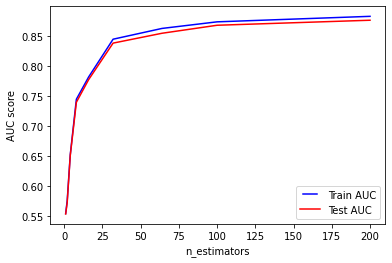

CPU times: user 51.3 s, sys: 2.41 s, total: 53.7 s
Wall time: 11.7 s


In [118]:
%%time
# USING CVEC
# N_estimators optimizer
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, max_depth=16, n_jobs=-2)
   rf.fit(xtrain_cv, y_train)
   train_pred = rf.predict(xtrain_cv)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(xtest_cv)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

## Note the above and below graphs are NOT the AUC - ROC curve, but this is a graph of how the AUC - ROC changes as n_estimators change. Clearly the higher the n_estimators, the better.

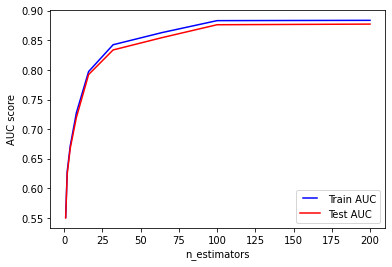

CPU times: user 53 s, sys: 2.32 s, total: 55.3 s
Wall time: 11.6 s


In [146]:
%%time
# USING TFIDF
# N_estimators optimizer
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, max_depth=16, n_jobs=-2)
   rf.fit(xtrain_tf, y_train)
   train_pred = rf.predict(xtrain_tf)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(xtest_tf)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

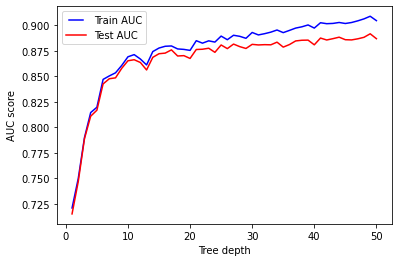

CPU times: user 23min 19s, sys: 26.3 s, total: 23min 45s
Wall time: 3min 54s


In [115]:
%%time
# USING CVEC
# Tree Depth optimizer taken from this Medium blog:
# https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d
from sklearn.metrics import roc_curve, auc
max_depths = np.linspace(1, 50, 50, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-2)
   rf.fit(xtrain_cv, y_train)
   train_pred = rf.predict(xtrain_cv)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(xtest_cv)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

As the tree depth grows, our models become more effective based on AUC, however they do eventually become overfit.

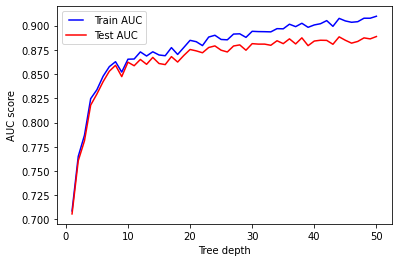

CPU times: user 23min 40s, sys: 26.6 s, total: 24min 6s
Wall time: 3min 59s


In [147]:
%%time
# USING TFIDF
# Tree Depth optimizer taken from this Medium blog:
# https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d
from sklearn.metrics import roc_curve, auc
max_depths = np.linspace(1, 50, 50, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-2)
   rf.fit(xtrain_tf, y_train)
   train_pred = rf.predict(xtrain_tf)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(xtest_tf)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

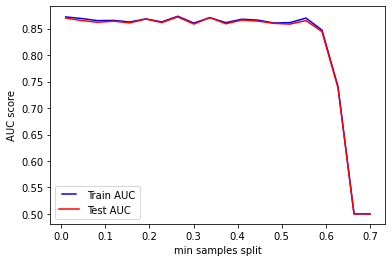

CPU times: user 1min 18s, sys: 2.37 s, total: 1min 20s
Wall time: 1min 20s


In [119]:
%%time
# USING CVEC
# Min Samples split optimizer taken from this Medium blog:
# https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

min_samples_splits = np.linspace(0.01, 0.7, 20, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   rf = RandomForestClassifier(min_samples_split=min_samples_split, max_depth=16)
   rf.fit(xtrain_cv, y_train)
   train_pred = rf.predict(xtrain_cv)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(xtest_cv)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

Clearly we cannot have a min samples split above 0.5 - 0.6.

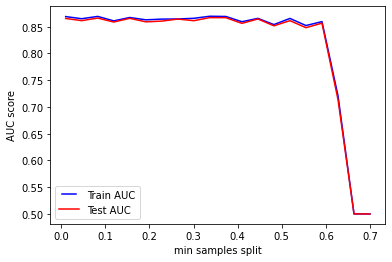

CPU times: user 1min 25s, sys: 2.37 s, total: 1min 28s
Wall time: 1min 28s


In [148]:
%%time
# USING TFIDF
# Min Samples split optimizer taken from this Medium blog:
# https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

min_samples_splits = np.linspace(0.01, 0.7, 20, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   rf = RandomForestClassifier(min_samples_split=min_samples_split, max_depth=16)
   rf.fit(xtrain_tf, y_train)
   train_pred = rf.predict(xtrain_tf)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(xtest_tf)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

In [123]:
np.linspace(0.01, 0.2, 20, endpoint=True)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ])

In [282]:
np.logspace(-2, 1, 20, endpoint=True)

array([ 0.01      ,  0.0143845 ,  0.02069138,  0.02976351,  0.04281332,
        0.06158482,  0.08858668,  0.1274275 ,  0.18329807,  0.26366509,
        0.37926902,  0.54555948,  0.78475997,  1.12883789,  1.62377674,
        2.33572147,  3.35981829,  4.83293024,  6.95192796, 10.        ])

Here I was attempting to develop a "logspace" to create more values between 0.0 and 0.1, however the line of code was not accepting of these values, possibly the quantity of digits gave it trouble.

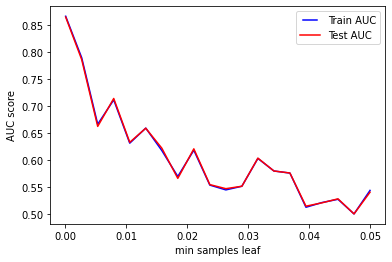

CPU times: user 53.1 s, sys: 2.39 s, total: 55.5 s
Wall time: 55.5 s


In [144]:
%%time
# USING CVEC
# Min Samples leaf optimizer taken from this Medium blog:
# https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

min_samples_leafs = np.linspace(0.0001, 0.05, 20, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf, max_depth=16)
   rf.fit(xtrain_cv, y_train)
   train_pred = rf.predict(xtrain_cv)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(xtest_cv)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

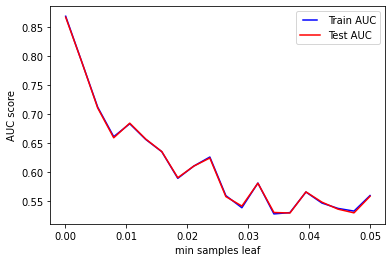

CPU times: user 55 s, sys: 2.38 s, total: 57.4 s
Wall time: 57.5 s


In [149]:
%%time
# USING TFIDF
# Min Samples leaf optimizer taken from this Medium blog:
# https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

min_samples_leafs = np.linspace(0.0001, 0.05, 20, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf, max_depth=16)
   rf.fit(xtrain_tf, y_train)
   train_pred = rf.predict(xtrain_tf)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(xtest_tf)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

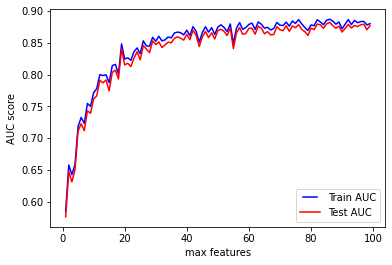

CPU times: user 7min, sys: 11.3 s, total: 7min 11s
Wall time: 7min 12s


In [121]:
%%time
# USING CVEC
# Max features optimizer taken from this Medium blog:
# https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

max_features = list(range(1,100))
train_results = []
test_results = []
for max_feature in max_features:
   rf = RandomForestClassifier(max_features=max_feature, max_depth=16)
   rf.fit(xtrain_cv, y_train)
   train_pred = rf.predict(xtrain_cv)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(xtest_cv)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

We clearly benefit from adding at least 40-60 features.

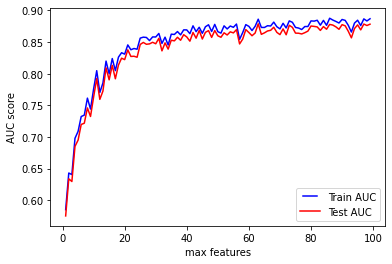

CPU times: user 7min 31s, sys: 13.1 s, total: 7min 44s
Wall time: 7min 51s


In [150]:
%%time
# USING TFIDF
# Max features optimizer taken from this Medium blog:
# https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

max_features = list(range(1,100))
train_results = []
test_results = []
for max_feature in max_features:
   rf = RandomForestClassifier(max_features=max_feature, max_depth=16)
   rf.fit(xtrain_tf, y_train)
   train_pred = rf.predict(xtrain_tf)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(xtest_tf)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

### Multinomial Naive-Bayes

In [259]:
%%time
# Instantiate two for CVEC and TFIDF
mnb_cv = MultinomialNB()
# mnb_tf = MultinomialNB()

# Fit both
mnb_cv.fit(xtrain_cv, y_train)
# mnb_tf.fit(xtrain_tf, y_train)

print(score(mnb_cv, xtrain_cv, y_train))
print(score(mnb_cv, xtest_cv, y_test))
# print(score(mnb_tf, xtrain_tf, y_train))
# print(score(mnb_tf, xtest_tf, y_test))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) test score: 0.95

Accuracy: 0.949
Sensitivity: 0.947
Specificity: 0.952
Precision: 0.952
None
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) test score: 0.94

Accuracy: 0.94
Sensitivity: 0.935
Specificity: 0.944
Precision: 0.944
None
CPU times: user 207 ms, sys: 16.7 ms, total: 223 ms
Wall time: 221 ms


This looks pretty good! And the difference between training and testing is small.

### Gaussian Naive-Bayes

In [210]:
gnb_cv = GaussianNB()
gnb_tf = GaussianNB()

# gnb_cv.fit(xtrain_cv, y_train)
gnb_tf.fit(xtrain_tf, y_train)

# print(score(mnb_cv, xtrain_cv, y_train))
# print(score(mnb_cv, xtest_cv, y_test))
print(score(mnb_tf, xtrain_tf, y_train))
print(score(mnb_tf, xtest_tf, y_test))

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

I was not able to get the Gaussian Naive Bayes model to work properly.

### Support Vector Model

In [241]:
# Instantiate
svm = LinearSVC()

In [261]:
# Create pipeline
svm_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('svm', LinearSVC(C=0.1))
])
svm_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('svm',
                 LinearSVC(C=0.1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=0.000

In [247]:
# Set up Parameters
svm_params = {"C": np.linspace(0.0001,1,20)}
# "C": np.linspace(0.1,1,2)
#     'kernel': ['rbf', 'linear', 'poly', 'sigmoid', 'precomputed']

In [248]:
svm_gs = GridSearchCV(svm, svm_params, cv=5)
svm_gs.fit(xtrain_cv, y_train)

/Users/colinsimon/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-04, 5.27263158e-02, 1.05352632e-01, 1.57978947e-01,
       2.10605263e-01, 2.63231579e-01, 3.15857895e-01, 3.68484211e-01,
       4.21110526e-01, 4.73736842e-01, 5.26363158e-01, 5.78989474e-01,
       6.31615789e-01, 6.84242105e-01, 7.36868421e-01, 7.89494737e-01,
       8.42121053e-01, 8.94747368e-01, 9.47373684e-01, 1.00000000e+00])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

##### Let's look for the best hyperparameter, 'C'

In [249]:
svm_gs.best_params_

{'C': 0.10535263157894738}

In [254]:
score(svm_gs, xtrain_cv, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-04, 5.27263158e-02, 1.05352632e-01, 1.57978947e-01,
       2.10605263e-01, 2.63231579e-01, 3.15857895e-01, 3.68484211e-01,
       4.21110526e-01, 4.73736842e-01, 5.26363158e-01, 5.78989474e-01,
       6.31615789e-01, 6.84242105e-01, 7.36868421e-01, 7.89494737e-01,
       8.42121053e-01, 8.94747368e-01, 9.47373684e-01, 1.00000000e+00])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0) test score: 0.96

Accuracy: 0.964
Sensitivity: 0.963
Specifici

The training scores look excellent!

In [255]:
score(svm_gs, xtest_cv, y_test)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-04, 5.27263158e-02, 1.05352632e-01, 1.57978947e-01,
       2.10605263e-01, 2.63231579e-01, 3.15857895e-01, 3.68484211e-01,
       4.21110526e-01, 4.73736842e-01, 5.26363158e-01, 5.78989474e-01,
       6.31615789e-01, 6.84242105e-01, 7.36868421e-01, 7.89494737e-01,
       8.42121053e-01, 8.94747368e-01, 9.47373684e-01, 1.00000000e+00])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0) test score: 0.94

Accuracy: 0.942
Sensitivity: 0.94
Specificit

##### Our testing scores look good, but not much better than logistic regression scores or MNB scores.

In [262]:
score(svm_pipe, X_train, y_train)

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('svm',
                 LinearSVC(C=0.1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=0.000

In [263]:
score(svm_pipe, X_test, y_test)

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('svm',
                 LinearSVC(C=0.1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=0.000

## Voting Classifier
##### Let's attempt to include the logistic regression, multinomial NB, and SVM models as they all scored very well.

In [251]:
%%time
# Voting Classifier
# CVEC and TFIDF instances
voter_cv = VotingClassifier([
            ('lr', LogisticRegression(solver='lbfgs', max_iter=1000)),
            ('mnb', MultinomialNB()),
            ('svm', LinearSVC(C=0.105))
#             ('rf', RandomForestClassifier(n_estimators=100, max_depth=16, random_state=42)) 
])
voter_tf = VotingClassifier([
            ('lr', LogisticRegression(solver='lbfgs', max_iter=1000)),
            ('mnb', MultinomialNB()),
            ('svm', LinearSVC(C=0.105))
#             ('rf', RandomForestClassifier(n_estimators=100, max_depth=16, random_state=42)) 
])

# Fit both
voter_cv.fit(xtrain_cv, y_train)
voter_tf.fit(xtrain_tf, y_train)

# metrics
print('CVEC Training Scores')
score(voter_cv, xtrain_cv, y_train)
print('\nTest Scores')
score(voter_cv, xtest_cv, y_test)

print('TFIDF Training Scores')
score(voter_tf, xtrain_tf, y_train)
print('\nTest Scores')
score(voter_tf, xtest_tf, y_test)

CVEC Training Scores
VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('mnb',
                              MultinomialNB(alpha=1.0, class_prior=None,
                                            fit_prior=True)),
                             ('svm',
                              LinearSVC(C=0.105, class_weig

##### Our Voting Classifier scored only marginally higher than each of these three models independently.

# 7. Conclusions and Selections

### Vectorizers:
We evaluated most models on both Count Vectorizer and Tfidf Vectorizer.

Count Vectorizer generally scored better. If we had to pick one, we'd definitely pick Count Vectorizer.

Tfidf Vectorizer was typically almost as accurate.
    - Tfidf followed most of the same patterns
    - This is particularly apparent in the Random Forest dissection

### Model Evaluations

Logistic Regression(Logreg):
    - Scored very well
    - Model runs quickly
    - We can gather coefficients if needed
    
Random Forest(RF):
    - Scored lower with current iterations
    - Highly customizeable; further exploration could possibly yield better results
    - Very computationally burdensome given 200,000 data points.

Multinomial Naive-Bayes(MNB):
    - Scored very well
    - Model runs shockingly fast
    
Support Vector Model(SVM):
    - Excellent score
    - Model struggled with data size; significant computational power requried
    - Further parameter optimization could improve results
    - Cloud computing or other boosted computational methods could improve results
    
Voting Classifier:
    - Nominally increased score
    - Probably not worth the complexity
    - Significant computational resources needed
    - Possible improvements from improved RF or SVM models

## Selections:

#### Models:
    1. Logistic Regression
    2. Multinomial Naive-Bayes
#### Vectorizers:
    1. Count Vectorizer
    

##### These selections might not yield the greatest results when observing interactions between other subreddits.

# 8. Bonus: Word Lists

In [265]:
# Get top words method adapted from: 
# https://www.kdnuggets.com/2019/05/complete-exploratory-data-analysis-visualization-text-data.html
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

Set of high-frequency words found in r/Frugal:

In [275]:
frugal_words = get_top_n_words(frugal['title'],50)
frugal_words

[('frugal', 10403),
 ('money', 6455),
 ('free', 5903),
 ('best', 5021),
 ('cheap', 4870),
 ('buy', 4654),
 ('save', 4561),
 ('car', 4271),
 ('new', 3865),
 ('need', 3792),
 ('way', 3324),
 ('help', 3210),
 ('good', 3195),
 ('tips', 3056),
 ('just', 2907),
 ('make', 2906),
 ('use', 2697),
 ('buying', 2508),
 ('food', 2459),
 ('advice', 2409),
 ('amazon', 2385),
 ('phone', 2343),
 ('time', 2306),
 ('looking', 2289),
 ('card', 2040),
 ('online', 2019),
 ('credit', 2002),
 ('home', 1999),
 ('10', 1897),
 ('price', 1856),
 ('year', 1853),
 ('don', 1821),
 ('budget', 1781),
 ('like', 1752),
 ('cheapest', 1665),
 ('saving', 1665),
 ('worth', 1656),
 ('insurance', 1631),
 ('month', 1606),
 ('amp', 1606),
 ('day', 1605),
 ('used', 1603),
 ('store', 1586),
 ('cost', 1516),
 ('know', 1510),
 ('does', 1501),
 ('want', 1472),
 ('gift', 1463),
 ('got', 1426),
 ('pay', 1412)]

Set of high-frequency words found in r/Investing:

In [276]:
investing_words = get_top_n_words(investing['title'],50)
investing_words

[('investing', 7483),
 ('stock', 7440),
 ('market', 6608),
 ('stocks', 5427),
 ('invest', 4811),
 ('buy', 3778),
 ('investment', 3395),
 ('advice', 3315),
 ('money', 2955),
 ('question', 2824),
 ('best', 2797),
 ('good', 2758),
 ('trading', 2596),
 ('funds', 2520),
 ('does', 2448),
 ('fund', 2400),
 ('amp', 2389),
 ('new', 2379),
 ('time', 2376),
 ('portfolio', 2339),
 ('etf', 2320),
 ('help', 2255),
 ('vs', 2224),
 ('long', 2140),
 ('thoughts', 2063),
 ('questions', 2056),
 ('company', 2045),
 ('index', 2014),
 ('year', 2009),
 ('just', 1875),
 ('looking', 1842),
 ('ira', 1841),
 ('term', 1836),
 ('companies', 1808),
 ('like', 1777),
 ('buying', 1644),
 ('account', 1621),
 ('etfs', 1619),
 ('price', 1553),
 ('trade', 1523),
 ('daily', 1512),
 ('options', 1504),
 ('sell', 1472),
 ('investors', 1460),
 ('roth', 1457),
 ('shares', 1446),
 ('today', 1445),
 ('make', 1444),
 ('years', 1439),
 ('vanguard', 1401)]